In [ ]:
!pip install opendatasets --quiet

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: klaus2twarz2
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mssmartypants/rice-type-classification


100%|██████████| 888k/888k [00:00<00:00, 714MB/s]

importy bibliotek

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

pytorch nie wykrywa gpu wiec trzeba mu je wskazac

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


dataset

In [ ]:
df = pd.read_csv('/content/rice-type-classification/riceClassification.csv')
df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


usuwanie brakujacych danych i kolumny id

In [ ]:
df.drop(columns=['id'], inplace=True)
df.dropna(inplace=True)

df.shape

(18185, 11)

In [ ]:
df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [ ]:
df['Class'].value_counts()

,count
Class,
1,9985
0,8200


normalizacja danych (lepsze małe wartości)

In [ ]:
org_df = df.copy()

In [ ]:
for column in df.columns:
  df[column] = df[column] / df[column].abs().max()

df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


bierzemy dane bez ostatniej kolumny czyli Class

In [ ]:
X = np.array(df.drop(columns=['Class']))
y = np.array(df['Class'])

dzielimy na treningowy, testowy i walidacyjny

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5)

In [ ]:
print(X_train.shape, X_val.shape, X_test.shape)

(12729, 10) (2728, 10) (2728, 10)


(DATASET) przekonwertowanie naszych danych na dane pytorch

In [ ]:
class dataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.tensor(X, dtype=torch.float32).to(device) #konwertujemy dane do torch.tensor o typie float32 to(device) oznacza, że przenosimy na GPU
    self.y = torch.tensor(y, dtype=torch.float32).to(device)

    #metody potrzedne do uczenia

  def __len__(self):   #metoda zwraca kształt wejscia naszych danych input
    return len(self.X)

  def __getitem__(self, idx):   # Zwracamy jedną próbkę (X, y) o indeksie idx, dzięki czemu możemy iterować po zbiorze
    return self.X[idx], self.y[idx]


obiekty dla treningu, walidacji i testu

In [ ]:
training_data  = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
test_data = dataset(X_test, y_test)

(DATALOADER) Obiekt, który służy do efektywnego ładowania i iterowania po zbiorze danych podczas treningu modelu.  
Pozwala na podział danych na batch'e, losowe mieszanie (shuffle) oraz wykonywanie pętli przez kolejne epoki,  
ułatwiając przetwarzanie dużych zbiorów i optymalizację uczenia.

czyli osiem danych (wektorów) na raz jest trenowanych i potem kolejne i tak dalej


In [ ]:
#batch_size=8 — liczba próbek w jednej partii (batchu) shuffle=True — losowe tasowanie danych przed każdą epoką
b_size = 32

train_dataloader = DataLoader(training_data, batch_size=b_size, shuffle=True)
val_dataloader = DataLoader(validation_data, batch_size=b_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=b_size, shuffle=True)

Tworzenie modelu

In [ ]:
Hidden_neurons = 10
class RiceModel(nn.Module):  #model dziedziczy po nn.Module
  def __init__(self):
    super(RiceModel, self).__init__()

    #tworzenie warstw uczenia

    self.input_layer = nn.Linear(X.shape[1], Hidden_neurons) #pierwsza warstwa 10 bo tyle wynosi X.shape druga sobie wybieramy jest to następna ukryta warstwa
    self.linear = nn.Linear(Hidden_neurons, 1) #1 ozancza output a nas insteresuje w sumie jedna wartość prawdpopodobieńtwo mniejsze 0.5 = 0 a większe od 0.5 = 1
    self.sigmoid = nn.Sigmoid() #funckja aktywacji sigmoid

    #pokazuje przepływ danych przez warstwy podczas uczenia

  def forward(self, x):
    x = self.input_layer(x)
    x = self.linear(x)
    x = self.sigmoid(x)
    return x

#tworzenie modelu to deive ze przenosimy obliczenia na gpu
model = RiceModel().to(device)

podgląd jak model wygląda

In [ ]:
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


Strata i optymalizator

In [ ]:
criterion = nn.BCELoss() #binarna strata entropii krzyżowej
optimizer = Adam(model.parameters(), lr=0.001) #optymalizator, który będzie aktualizował wagi Twojego modelu podczas treningu.

funkcja szkoleniowa

In [ ]:
total_loss_train_plot = [] #strata
total_loss_val_plot = []
total_acc_train_plot = [] #dokładność
total_acc_val_plot = []

epochs = 10

for epoch in range(epochs):
  total_acc_train = 0
  total_loss_train = 0
  total_acc_val = 0
  total_loss_val = 0

  for data in train_dataloader: #data to inputs i label. inputs to wejscia (8 wierszy) a label to etykiety do nich
    inputs, labels = data

    #propagacja w przód

    prediction = model(inputs).squeeze(1) #tworzymy predykcje .squeeze(1) usuwa wymiar o indeksie 1, jeśli jego rozmiar to 1.

    #prediction ma shape [8, 1] a potrzebujemy [8] dlatego squeeze

    batch_loss = criterion(prediction, labels)
    total_loss_train += batch_loss.item() #item Zamienia tensor zawierający pojedynczą liczbę (scalar) na zwykły Pythonowy float. tensor([2.37]) na 2.37 (float)

    acc = ((prediction).round() == labels).sum().item() #dokładnosc czyli ile jest dobrych z posrod osmiu na epoke
    total_acc_train += acc

    #propagacja wsteczna
    batch_loss.backward() # oblicza gradienty (backpropagation) dla wszystkich parametrów modelu względem straty (wstecz)
    optimizer.step()      # aktualizacja wag na podstawie gradientów
    optimizer.zero_grad() # zerowanie gradientów przed kolejną iteracją

  #walicacja
  #uzyj modelu nie do treingu ale do testowania, przygotowanie modelu do przewidywania ale bez zmian
  #tutaj glownie kopiujemy z treningu tylko zmieniamy na val
  with torch.no_grad():
    for data in val_dataloader:
      inputs, labels = data
      prediction = model(inputs).squeeze(1)
      batch_loss = criterion(prediction, labels)
      total_loss_val += batch_loss.item()

      acc = ((prediction).round() == labels).sum().item()
      total_acc_val += acc


  #rysowanie wykresów normalizacja ogromnych liczb przez 1000

  fin_total_loss_train = round(total_loss_train /1000, 4)
  fin_total_loss_val = round(total_loss_val /1000, 4)
  fin_total_acc_train = round(total_acc_train /training_data.__len__() * 100, 4) #tutaj procentu np mamy 6 popawnych z 10 i to procnt. len daje nam dlugosc danych
  fin_total_acc_val = round(total_acc_val /validation_data.__len__() * 100, 4)


  total_loss_train_plot.append(fin_total_loss_train)
  total_loss_val_plot.append(fin_total_loss_val)
  total_acc_train_plot.append(fin_total_acc_train)
  total_acc_val_plot.append(fin_total_acc_val)

  print(f'''Epoch no. {epoch + 1} Train Loss: {fin_total_loss_train} Train Accuracy: {fin_total_acc_train} Validation Loss: {fin_total_loss_val} Validation Accuracy: {fin_total_acc_val}''')
  print("="*25)



Epoch no. 1 Train Loss: 0.2288 Train Accuracy: 88.3337 Validation Loss: 0.0366 Validation Accuracy: 97.6173
Epoch no. 2 Train Loss: 0.1136 Train Accuracy: 97.9417 Validation Loss: 0.0156 Validation Accuracy: 98.5704
Epoch no. 3 Train Loss: 0.0544 Train Accuracy: 98.1617 Validation Loss: 0.0088 Validation Accuracy: 98.607
Epoch no. 4 Train Loss: 0.0354 Train Accuracy: 98.3738 Validation Loss: 0.0065 Validation Accuracy: 98.7537
Epoch no. 5 Train Loss: 0.0276 Train Accuracy: 98.4681 Validation Loss: 0.0057 Validation Accuracy: 98.7537
Epoch no. 6 Train Loss: 0.0238 Train Accuracy: 98.5073 Validation Loss: 0.0047 Validation Accuracy: 98.607
Epoch no. 7 Train Loss: 0.0214 Train Accuracy: 98.4995 Validation Loss: 0.0043 Validation Accuracy: 98.6437
Epoch no. 8 Train Loss: 0.02 Train Accuracy: 98.5781 Validation Loss: 0.004 Validation Accuracy: 98.6437
Epoch no. 9 Train Loss: 0.0191 Train Accuracy: 98.5231 Validation Loss: 0.0041 Validation Accuracy: 98.9003
Epoch no. 10 Train Loss: 0.0183 T

Testowanie modelu

In [ ]:
with torch.no_grad(): #wyłączasz śledzenie obliczeń potrzebnych do obliczania gradientów
  total_loss_test = 0
  total_acc_test = 0
  for data in test_dataloader:
    inputs, labels = data
    prediction = model(inputs).squeeze(1)

    batch_loss_test = criterion(prediction, labels).item()
    total_loss_test += batch_loss_test

    acc = ((prediction).round() == labels).sum().item()
    total_acc_test += acc

fin_total_loss_test = round(total_loss_test /1000, 4)
fin_total_acc_test = round(total_acc_test /test_data.__len__() * 100, 4)

print("Accuracy: ", fin_total_acc_test)

Accuracy:  98.937


wizualizacja

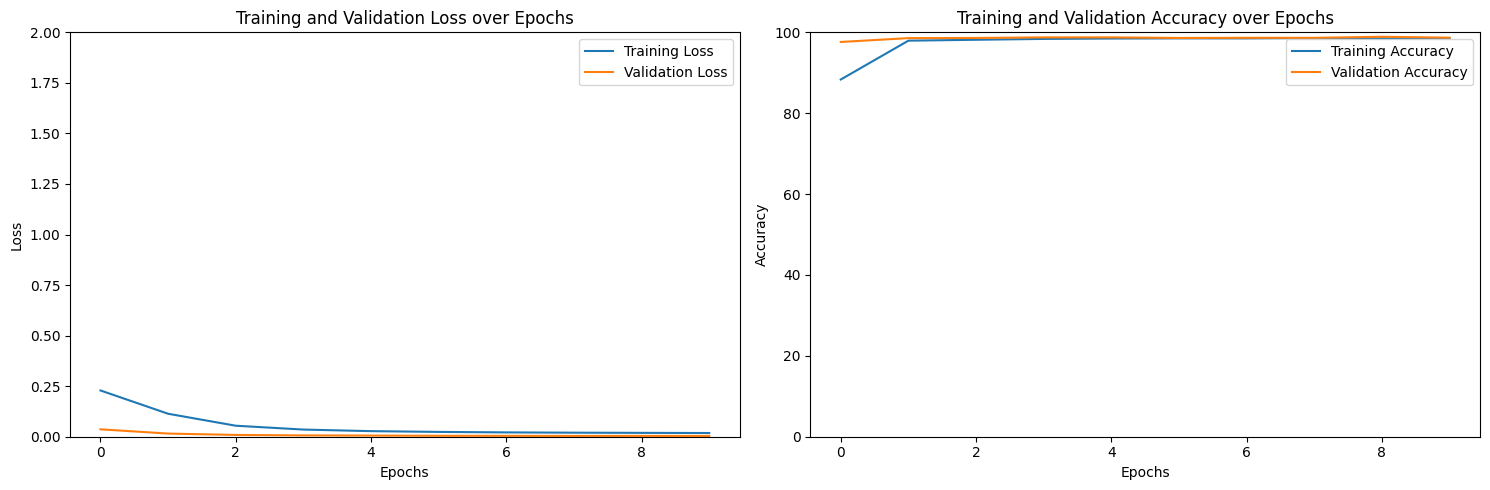

In [ ]:
ig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_val_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_val_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()

inferencja i test modelu czy dziala

In [ ]:
org_df.columns


Index(['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
       'ConvexArea', 'EquivDiameter', 'Extent', 'Perimeter', 'Roundness',
       'AspectRation', 'Class'],
      dtype='object')

In [ ]:
area = float(input("Area: "))/org_df['Area'].abs().max()
MajorAxisLength = float(input("Major Axis Length: "))/org_df['MajorAxisLength'].abs().max()
MinorAxisLength = float(input("Minor Axis Length: "))/org_df['MinorAxisLength'].abs().max()
Eccentricity = float(input("Eccentricity: "))/org_df['Eccentricity'].abs().max()
ConvexArea = float(input("Convex Area: "))/org_df['ConvexArea'].abs().max()
EquivDiameter = float(input("EquivDiameter: "))/org_df['EquivDiameter'].abs().max()
Extent = float(input("Extent: "))/org_df['Extent'].abs().max()
Perimeter = float(input("Perimeter: "))/org_df['Perimeter'].abs().max()
Roundness = float(input("Roundness: "))/org_df['Roundness'].abs().max()
AspectRation = float(input("AspectRation: "))/org_df['AspectRation'].abs().max()
3
my_inputs = [area, MajorAxisLength, MinorAxisLength, Eccentricity, ConvexArea, EquivDiameter, Extent, Perimeter, Roundness, AspectRation]

print("="*20)
model_inputs = torch.Tensor(my_inputs).to(device)
prediction = (model(model_inputs))
print(prediction)
print("Class is: ", round(prediction.item()))

Area: 33
Major Axis Length: 22
Minor Axis Length: 321
Eccentricity: 4
Convex Area: 55
EquivDiameter: 2
Extent: 3
Perimeter: 88
Roundness: 96
AspectRation: 2
tensor([0.], device='cuda:0', grad_fn=<SigmoidBackward0>)
Class is:  0
